## Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import layers

## Data

### Import Data

In [8]:
# Get the helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-09-11 18:47:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-09-11 18:47:40 (81.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
# get the fruit and vegetables data from kaggle
!wget https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification

--2024-09-11 18:24:09--  https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘fruits-fresh-and-rotten-for-classification’

fruits-fresh-and-ro     [ <=>                ]   9.00K  --.-KB/s    in 0.01s   

2024-09-11 18:24:09 (902 KB/s) - ‘fruits-fresh-and-rotten-for-classification’ saved [9217]



In [1]:
from google.colab import files
uploaded  = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [2]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
100% 1.98G/1.98G [00:26<00:00, 134MB/s]
100% 1.98G/1.98G [00:27<00:00, 76.2MB/s]


In [9]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

unzip_data('fruit-and-vegetable-image-recognition.zip')

In [10]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['apple' 'banana' 'beetroot' 'bell pepper' 'cabbage' 'capsicum' 'carrot'
 'cauliflower' 'chilli pepper' 'corn' 'cucumber' 'eggplant' 'garlic'
 'ginger' 'grapes' 'jalepeno' 'kiwi' 'lemon' 'lettuce' 'mango' 'onion'
 'orange' 'paprika' 'pear' 'peas' 'pineapple' 'pomegranate' 'potato'
 'raddish' 'soy beans' 'spinach' 'sweetcorn' 'sweetpotato' 'tomato'
 'turnip' 'watermelon']


In [11]:
len(class_names)

36

### Data Visualization

In [14]:
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (450, 600, 3)
Image shape: (1254, 836, 3)
Image shape: (945, 1132, 3)
Image shape: (3072, 2304, 3)
Image shape: (425, 425, 3)
Image shape: (268, 465, 3)


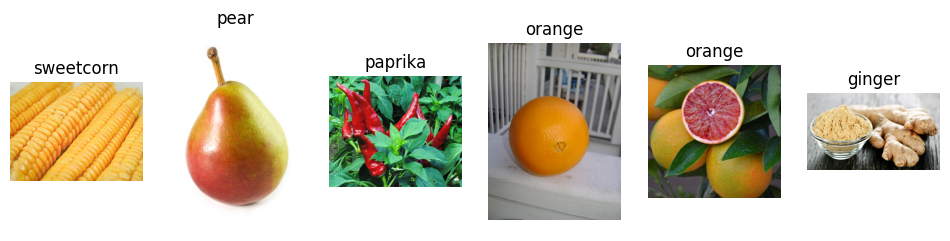

In [24]:
# View a random image from the training dataset
plt.figure(figsize = (12, 12))
plt.subplot(1, 6, 1)
img_1 = view_random_image("/content/train/", "sweetcorn")
plt.subplot(1, 6, 2)
img_2 = view_random_image("/content/train/", "pear")
plt.subplot(1, 6, 3)
img_3 = view_random_image("/content/train/", "paprika")
plt.subplot(1, 6, 4)
img_4 = view_random_image("/content/train/", "orange")
plt.subplot(1, 6, 5)
img_5 = view_random_image("/content/train/", "orange")
plt.subplot(1, 6, 6)
img_6 = view_random_image("/content/train/", "ginger")

### Data preprocessing

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                   rotation_range=20,              # Rorate images by factor 20 degree
                                   width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
                                   height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
                                   zoom_range=0.1,                 # Zoom in and out images by 10%
                                   horizontal_flip=True,           # Allow horizontal flipping
                                   shear_range=0.1,                # shear images by 10% their size
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255,)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# training image preprocessing
training_set = train_datagen.flow_from_directory(
    "/content/train",
    class_mode = "categorical",
    color_mode = "rgb",
    batch_size = 32,
    target_size = (64, 64),
    shuffle = True,
    seed = 42
)
# validation image preprocessing
validation_set = validation_datagen.flow_from_directory(
    "/content/validation",
    class_mode = "categorical",
    color_mode = "rgb",
    batch_size = 32,
    target_size = (64, 64),
    shuffle = True,
    seed = 42
)
# testing imaeg preprocessing
testing_set = test_datagen.flow_from_directory(
    "/content/test",
    class_mode = "categorical",
    color_mode = "rgb",
    batch_size = 32,
    target_size = (64, 64),
    shuffle = True,
    seed = 42
)

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


## Modeling

### Model 1: Simple Convolution Layer

In [36]:
tf.random.set_seed(42)

# Create a simple CNN model
Model_1 = tf.keras.Sequential([
  layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = "relu", input_shape = [64, 64, 3]),
  layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu"),
  layers.MaxPool2D(pool_size = 2, strides = 2),
  layers.Dropout(0.25),
  layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu", padding = 'same'),
  layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu"),
  layers.MaxPool2D(pool_size = 2, strides = 2),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(units = 512, activation = "relu"),
  layers.Dense(units = 256, activation = "relu"),
  layers.Dropout(0.5),
  layers.Dense(units = len(class_names), activation = 'softmax')
])
Model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)
Model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 62, 62, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,629,188 (25.29 MB)

 Trainable params: 6,629,188 (25.29 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# fit the Model
Model_1_history = Model_1.fit(
    training_set,
    epochs = 40,
    validation_data = validation_set
    )

Epoch 1/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 106s 963ms/step - accuracy: 0.0326 - loss: 3.5857 - val_accuracy: 0.0655 - val_loss: 3.2828
Epoch 2/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 793ms/step - accuracy: 0.0628 - loss: 3.3512 - val_accuracy: 0.1026 - val_loss: 3.0609
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 806ms/step - accuracy: 0.0884 - loss: 3.1765 - val_accuracy: 0.1738 - val_loss: 2.6352
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 808ms/step - accuracy: 0.1172 - loss: 2.9711 - val_accuracy: 0.2621 - val_loss: 2.3678
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 142s 802ms/step - accuracy: 0.1668 - loss: 2.7735 - val_accuracy: 0.3219 - val_loss: 2.1242
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 788ms/step - accuracy: 0.1964 - loss: 2.6697 - val_accuracy: 0.3647 - val_loss: 2.0733
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 807ms/step - accuracy: 0.2033 - loss: 2.5734 - val_accuracy: 0.3675 - val_loss: 2.0231
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 141s 806ms/step - accuracy: 0.2212 - loss: 2.5123 - val_

In [38]:
train_loss, train_acc = Model_1.evaluate(training_set)
print('Training accuracy:', train_acc)

98/98 ━━━━━━━━━━━━━━━━━━━━ 73s 740ms/step - accuracy: 0.5505 - loss: 1.3944
Training accuracy: 0.5512038469314575


In [39]:
val_loss, val_acc = Model_1.evaluate(validation_set)
print('Validation accuracy:', val_acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 872ms/step - accuracy: 0.7024 - loss: 0.9372
Validation accuracy: 0.692307710647583


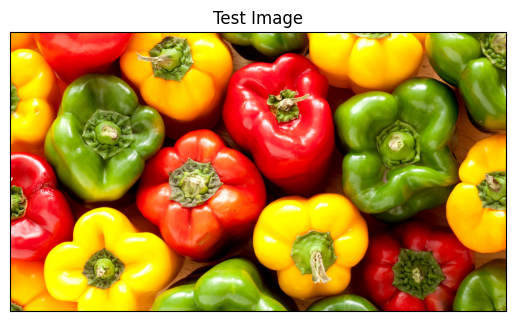

In [47]:
import cv2
image_path = '/content/test/capsicum/Image_1.jpg'
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [48]:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(64,64))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = Model_1.predict(input_arr)
result_index = np.argmax(predictions) #Return index of max element
print(result_index)
print(class_names[result_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5
capsicum
